## Main Functions Tests

### Octree Tests; with Transformation from forest

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from typing import Optional, List
from simesh.frontends.amrvac.datio import get_header, get_forest, get_tree_info, get_single_block_data
from simesh.geometry.amr.morton_order import encode_Morton, level1_Morton_order
from simesh.geometry.amr.amr_forest import AMRForest
from simesh.utils.octree import OctreeNode, OctreeNodePointer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
testf = './data/tdm0.dat'
with open(testf, 'rb') as f:
    header = get_header(f)
    forest = get_forest(f)
    tree = get_tree_info(f)

nleafs = header['nleafs']
ngs = np.array(header['domain_nx']/header['block_nx'], dtype=int)

In [27]:
ngs = np.array([2,2,2], dtype=int)
forest = np.ones(np.prod(ngs)+8, dtype=bool)
forest[1] = False
nleafs = np.where(forest == True)[0].shape[0]

In [28]:
forest_test = AMRForest(ngs[0], ngs[1], ngs[2], nleafs)
forest_test.read_forest(forest)

In [29]:
forest_test.build_connectivity()

In [13]:
forest_test.neighbor_child[2,:,:,0]

array([[2, 6, 0, 0],
       [4, 8, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

### Mesh Tests: ghost cells filling

In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
from typing import Optional, List
from simesh.geometry.amr.amr_forest import AMRForest
from simesh.utils.octree import OctreeNodePointer
from simesh.meshes.amr_mesh import AMRMesh

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
xrange = (0., 1.)
yrange = (0., 1.)
zrange = (0., 1.)
field_names = ['density', 'magnetic_field']
nleafs = 15
block_nx = np.array([4, 4, 4])
domain_nx = np.array([8, 8, 8])
nghostcells = 2

# Create forest configuration
forest = AMRForest(ng1=2, ng2=2, ng3=2, nleafs=15)
forest_config = np.ones(16, dtype=bool)
forest_config[1] = False  # Second element is non-leaf
forest.read_forest(forest_config)
forest.build_connectivity()

forest0 = AMRForest(ng1=2, ng2=2, ng3=2, nleafs=8)
forest_config0 = np.ones(8, dtype=bool)
forest0.read_forest(forest_config0)
forest0.build_connectivity()

# Create mesh
mesh = AMRMesh(
    xrange, yrange, zrange,
    field_names, block_nx, domain_nx,
    forest,
    nghostcells=nghostcells,
)

# Fill data with ones
mesh.data[:,2:6,2:6,2:6,:] = 1

In [3]:
mesh.getbc()

Fill Boundary Before GC
Fill Coarse Boundary
Fill Sibling and coarser gc
Fill Prolong gc (in coarse data)
Fill Prolong gc (in fine data)
Fill gc After GC


In [4]:
np.all(mesh.data)

True

### Datio Tests for real .dat file

In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
from typing import Optional, List
from simesh.frontends.amrvac.datio import get_header, get_forest, get_tree_info, get_single_block_data
from simesh.geometry.amr.morton_order import encode_Morton, level1_Morton_order
from simesh.geometry.amr.amr_forest import AMRForest
from simesh.dataset.data_set import AMRDataSet
from simesh.meshes.amr_mesh import AMRMesh
from simesh.utils.octree import OctreeNode, OctreeNodePointer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# temporary loader to load the .dat file for testing
path = './data/weno511_sub_0000.dat'
with open(path, 'rb') as file:
    header = get_header(file)
    forest = get_forest(file)
    tree_info = get_tree_info(file)

    xmin = header['xmin']
    xmax = header['xmax']
    field_names = header['w_names']
    nleafs = header['nleafs']
    block_nx = header['block_nx']
    domain_nx = header['domain_nx']
    nblev1 = domain_nx // block_nx
    nghostcells = 2

    forest_amr = AMRForest(*nblev1, nleafs)
    forest_amr.read_forest(forest)
    forest_amr.build_connectivity()

    mesh = AMRMesh((xmin[0],xmax[0]), (xmin[1], xmax[1]), (xmin[2], xmax[2]), 
                   field_names, block_nx, domain_nx, forest_amr, nghostcells=2)
    
    ds = AMRDataSet(mesh, path, header, forest, tree_info, field_names)
    ds1 = AMRDataSet(mesh, path, header, forest, tree_info, field_names)
    ds.load_data(load_ghost=False)
    ds.mesh.getbc()

Load Clear


In [45]:
ds.mesh._init_field_idx()
ds.mesh.load_current()
slab_current = ds.mesh.export_uniform_current([-0.5,-0.5,0], [0.5,0.5,1.3],200,200,200)

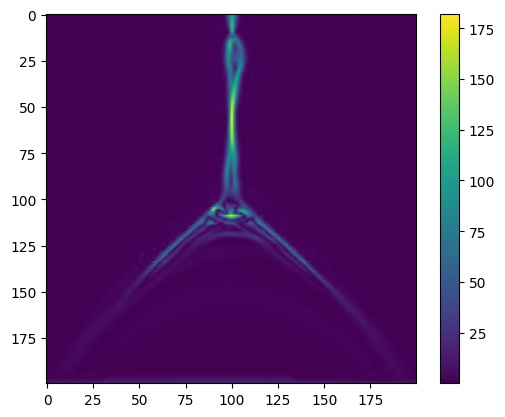

In [49]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
abs_current = np.abs(slab_current)
plt.imshow(np.rot90(abs_current[:,100,:,1]))
plt.colorbar()

In [20]:
slab_all = ds.mesh.export_slab_uniform([-4,-4,0], [4,4,8],200,200,200)

In [21]:
b1= slab_all[:,:,:,4]
b2 = slab_all[:,:,:,5]
b3 = slab_all[:,:,:,6]

In [22]:
import numpy as np

def calculate_current(b1, b2, b3, dx, dy, dz):
    """
    Calculate current density from magnetic field components using curl(B)
    
    Parameters:
    -----------
    b1, b2, b3 : ndarray
        Magnetic field components (nx, ny, nz)
    dx, dy, dz : float
        Grid spacing in x, y, z directions
    
    Returns:
    --------
    j1, j2, j3 : ndarray
        Current density components
    """
    # Calculate derivatives using central differences
    # j1 = ∂B3/∂y - ∂B2/∂z
    # j2 = ∂B1/∂z - ∂B3/∂x
    # j3 = ∂B2/∂x - ∂B1/∂y
    
    j1 = (np.gradient(b3, dy, axis=1) - np.gradient(b2, dz, axis=2))
    j2 = (np.gradient(b1, dz, axis=2) - np.gradient(b3, dx, axis=0))
    j3 = (np.gradient(b2, dx, axis=0) - np.gradient(b1, dy, axis=1))
    
    return j1, j2, j3

b1 = slab_all[:,:,:,4]
b2 = slab_all[:,:,:,5]
b3 = slab_all[:,:,:,6]

current = np.stack(calculate_current(b1, b2, b3, 0.04, 0.04, 0.04), axis=-1)

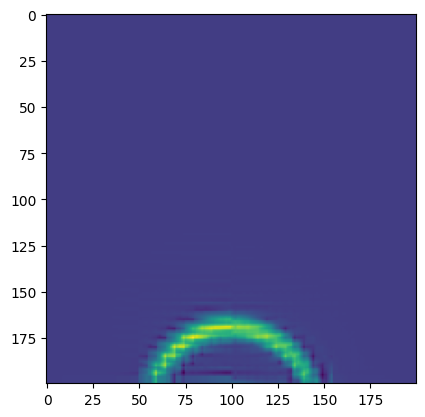

In [23]:
plt.imshow(np.rot90(current[100,:,:,1]))


## Algorithm Tests

### Test on the Magic of Extending 10 bits to One Morton Number 

In [40]:
import time
from functools import wraps

def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record the start time
        result = func(*args, **kwargs)  # Call the original function
        end_time = time.time()  # Record the end time
        elapsed_time = end_time - start_time  # Calculate the elapsed time
        print(f"Function '{func.__name__}' executed in {elapsed_time:.5f} seconds")
        return result  # Return the result of the original function
    return wrapper

def interleave_bits(ign):
    answer = 0
    ndim = len(ign)
    for i in range(0,64//ndim):  

        if ndim == 1:
            return ign[0]

        elif ndim == 2:
            bit_x = (ign[0] >> i) & 1
            bit_y = (ign[1] >> i) & 1

            answer |= (bit_x << (2*i)) | (bit_y << (2*i + 1))
        
        elif ndim == 3:
            bit_x = (ign[0] >> i) & 1
            bit_y = (ign[1] >> i) & 1
            bit_z = (ign[2] >> i) & 1

            answer |= (bit_x << (3*i)) | (bit_y << (3*i + 1)) | (bit_z << (3*i + 2))
        
    return answer

def inb(ign):
    x, y, z = ign
    def extract_bit(x):
        x = (x | (x << 16)) & 0x030000FF;
        x = (x | (x <<  8)) & 0x0300F00F;
        x = (x | (x <<  4)) & 0x030C30C3;
        x = (x | (x <<  2)) & 0x09249249;
        return x
    x, y, z= extract_bit(x), extract_bit(y), extract_bit(z)
    return x | (y << 1) | (z << 2)

@timeit
def test_inb(ign):
    for i in range(10000):
        inb(ign)

@timeit
def test_int(ign):
    for i in range(10000):
        interleave_bits(ign)

In [48]:
inb(np.array([1,1,1])-1)+1

1

In [31]:
test_inb([1,2,3])

Function 'test_inb' executed in 0.01950 seconds


In [32]:
test_int([1,2,34])

Function 'test_int' executed in 0.13355 seconds


In [51]:
def hex_to_binary_and_find_all_non_zero_positions(hex_number):
    # Convert the hexadecimal number to an integer
    num = int(hex_number, 16)
    
    # Convert the integer to a binary string, removing the '0b' prefix
    binary_string = bin(num)[2:]
    
    # Pad the binary string with leading zeros to make it a full 16-bit representation
    binary_string = binary_string.zfill(16)
    
    # Find all positions of non-zero bits
    non_zero_positions = [i for i, bit in enumerate(binary_string) if bit == '1']
    
    return binary_string, non_zero_positions

# Example usage
hex_number = "0x030C30C3"
binary_string, positions = hex_to_binary_and_find_all_non_zero_positions(hex_number)
print(f"Binary representation: {binary_string}, Non-zero positions: {positions}")

Binary representation: 11000011000011000011000011, Non-zero positions: [0, 1, 6, 7, 12, 13, 18, 19, 24, 25]


In [43]:
(1 << 16 | 1) & 0x030000FF

1

### check bipolar field vector potential in TDm configuration

In [148]:
q_para = 1
L_para = 0.8
d_para = 0.6
def bipolar_Avec(x:np.ndarray, y:np.ndarray, z:np.ndarray, 
                 q_para:float, L_para:float, d_para:float):
    Avec = np.zeros((3, *x.shape))
    cos1 = (x-L_para) / np.sqrt(y**2+(z+d_para)**2+(x-L_para)**2)
    cos2 = (L_para+x) / np.sqrt(y**2+(z+d_para)**2+(x+L_para)**2)
    Aphi  = cos1 * q_para - cos2 * q_para

    Avec[0] = 0.0
    Avec[1] = -Aphi * (z+d_para)/(y**2+(z+d_para)**2)
    Avec[2] = Aphi * y/(y**2+(z+d_para)**2)

    bbp = np.zeros_like(Avec)
    tmp = np.sqrt(y**2+(z+d_para)**2+(x+L_para)**2)**3
    bbp[0] = (x+L_para)/tmp
    bbp[1] = y/tmp
    bbp[2] = (z+d_para)/tmp
    tmp = np.sqrt(y**2+(z+d_para)**2+(x-L_para)**2)**3
    bbp[0] = bbp[0] - (x-L_para)/tmp
    bbp[1] = bbp[1] - y/tmp
    bbp[2] = bbp[2] - (z+d_para)/tmp

    return Avec, bbp

def bipolar_Avec2(x, y, z, q_para, L_para, d_para):
    Avec = np.zeros((3, *x.shape))

    Aphi = q_para * (L_para-x) / np.sqrt(y**2+(z+d_para)**2+(x-L_para)**2) / \
            np.sqrt(y**2+(z+d_para)**2) + \
            q_para * (L_para+x) / np.sqrt(y**2+(z+d_para)**2+(x+L_para)**2) / \
            np.sqrt(y**2+(z+d_para)**2)

    Avec[0] = 0.0
    Avec[1] = -Aphi * (z+d_para)/(y**2+(z+d_para)**2)
    Avec[2] = Aphi * y/(y**2+(z+d_para)**2)
    return Avec

def curlvec(vec):
    curl = np.zeros_like(vec)
    # curl_x = dAz/dy - dAy/dz
    curl[0] = np.gradient(vec[2], axis=1) - np.gradient(vec[1], axis=2)
    # curl_y = dAx/dz - dAz/dx  
    curl[1] = np.gradient(vec[0], axis=2) - np.gradient(vec[2], axis=0)
    # curl_z = dAy/dx - dAx/dy
    curl[2] = np.gradient(vec[1], axis=0) - np.gradient(vec[0], axis=1)
    return curl


In [152]:
x = np.linspace(-0.1, 0.1, 200)
y = np.linspace(-0.1, 0.1, 200) 
z = np.linspace(0, 0.2, 200)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
Avec, bbp = bipolar_Avec(X, Y, Z, q_para, L_para, d_para)
bbp_vec = curlvec(Avec)
Avec2 = bipolar_Avec2(X, Y, Z, q_para, L_para, d_para)
bbp2_vec = curlvec(Avec2)

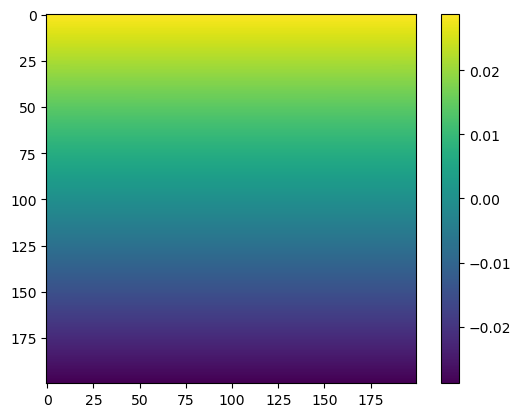

In [135]:
import matplotlib.pyplot as plt
plt.imshow(bbp[2][:,:,2])
plt.colorbar()

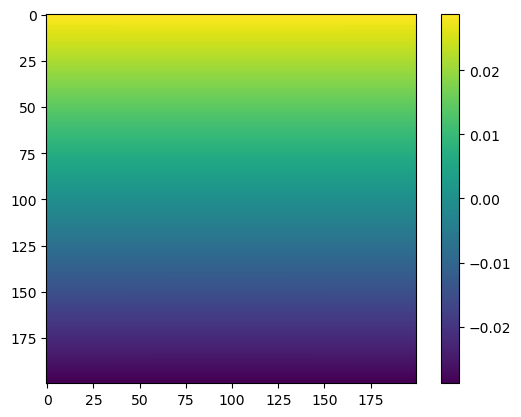

In [136]:
plt.imshow(bbp_vec[2][:,:,2] * 1e4)
plt.colorbar()

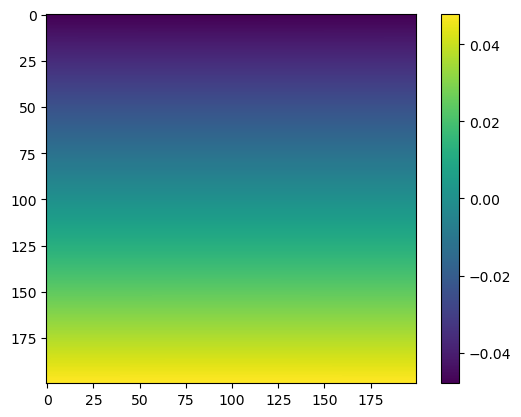

In [137]:
plt.imshow(bbp2_vec[2][:,:,2] * 1e4)
plt.colorbar()